# MSA CAT GPLVM

I <3 Acryonyms

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
from pyro_gp_utils import *
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from torch.nn import Parameter
import h5py

In [19]:
def save_gp(gpmodel, fname):
    """
    Saves all the named parameters from a pyro GP model to an h5 file with each parameter name matching the datset label.
    Have to recommend that you name the file something that describes which kernels were used since there are absolutely no
    checks or controls on whether the parameters match up. An annoying thing will be that if you make a composite kernel 
    in a different order the parameters of the kernels will be swapped.
    """
    f = h5py.File(fname,'x')
    for name, param in gpmodel.named_parameters():
        f.create_dataset(name, data=param.clone().detach().cpu().numpy())
    f.close()
    
def load_gp(gpmodel, fname):
    f = h5py.File(fname, 'r')
    for name, param in gpmodel.named_parameters():
        param = torch.tensor(f.get(name)[()])

In [2]:
def int_msa(fname):
    """
    Return a one hot encoded multiple sequence alignment from a fasta file and ordered list of characters for
    decoding with `one_hot_to_aa`
    """
    names = []
    seq_strings = []
    with open(fname) as f:
        for line in f:
            if line.startswith('>'):
                names.append(line.strip())
                seq_strings.append([])
            else:
                seq_strings[-1] += list(line.strip())
    aa_to_int = dict(zip(np.unique(seq_strings), np.arange(np.unique(seq_strings).shape[0])))
    msa = np.zeros((len(seq_strings),len(seq_strings[0])))
    for i, seq in enumerate(seq_strings):
        for j, res in enumerate(seq_strings[i]):
            msa[i,j] = aa_to_int[res]
    return msa.astype(np.int), np.unique(seq_strings)
# def one_hot_to_aa(ohv,labels):
#     return labels[np.argmax(ohv)]

In [3]:
msa, labels = int_msa('/home/paperspace/data/P0ABQ4.fas')

In [4]:
gaps = np.sum(msa == 0,axis=1)

In [5]:
gaps.max()/msa.shape[1]

0.24528301886792453

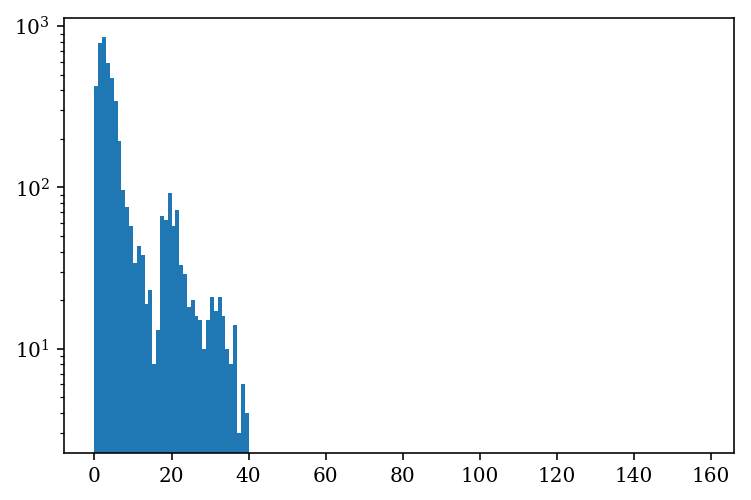

In [6]:
plt.hist(gaps, bins= np.arange(msa.shape[1]))
plt.semilogy()
plt.show()

In [7]:
#Set up training data
#torch.set_default_dtype(torch.float)
latent_dim=5
Y = torch.tensor(msa).to(torch.get_default_dtype())

#U, S, V = Y.svd()
#X_init = U.mm(torch.diag(S)[:,:latent_dim]).to(torch.get_default_dtype())
X_init = torch.randn((msa.shape[1],latent_dim))
# No real testing data here, were just trying learn a good embedding = but use anyway for BCE Loss purposes


#Set up kernel parameters
l0 = 5*torch.ones(latent_dim)
#Set up likelihood
likelihood = gp.likelihoods.MultiClass(labels.shape[0])

#Set up inducing points by downsampling the training data
n_inducing = 50
inds = torch.randperm(X_init.shape[0])[:n_inducing]
Xu = X_init[inds]
yu = Y[inds]

#Set up latent Xs as parameter
X = Parameter(X_init)

batch_size=100
Y_test = Y[-batch_size:]

In [8]:
print(X_init.shape)
print(Y.shape)

torch.Size([159, 5])
torch.Size([4706, 159])


In [16]:
def batch_gplvm_train(gpmodel, X, Y, loss_fn=pyro.infer.TraceMeanField_ELBO().differentiable_loss,
                      optimizer=torch.optim.Adam, lr=0.0025, num_epochs=20, num_steps=200, batch_size=100):
    opt = optimizer(gpmodel.parameters(), lr=lr)
    schedule = torch.optim.lr_scheduler.StepLR(opt, 1000,gamma=0.25)
    losses = [] 
    for e in range(num_epochs):
        # Set the batch
        gpmodel.y = Y[torch.randperm(Y.shape[0])[:batch_size]].cuda()
        #Take the steps
        for i in range(num_steps):
            opt.zero_grad()
            loss = loss_fn(gpmodel.model, gpmodel.guide)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        schedule.step()
        # Show some output
        print(f'Epoch {e+1}  -- Loss = {losses[-1]} -- '+test_categorical_gplvm(gpmodel,Y[torch.randperm(Y.shape[0])[:batch_size]].cuda()),end='\r')
        #-- Accuracy = {test_binary(gpmodel,X_test,Y_test,cuda)}
    return losses

In [12]:
def test_categorical_gplvm(gpmodel, y_test):
    with torch.no_grad():
        loc, scale = gpmodel(gpmodel.X)
        pred = gpmodel.likelihood(loc, scale)
        likelihood = gpmodel.likelihood(loc, scale)
        acc = pred.eq(y_test.to(torch.long).cuda()).sum().to(torch.float)/y_test.numel()
        cce = torch.nn.CrossEntropyLoss(reduction='mean')(loc,y_test.to(torch.long).cuda())
    return f'Accuracy: {acc:0.5f} -- CCELoss: {cce:0.5f}'

In [22]:
test_categorical_gplvm(gplvm, Y_test)

'Accuracy: 0.14648 -- CCELoss: 2.44027'

In [14]:
K = gp.kernels.RBF(input_dim=latent_dim,lengthscale=l0)
K = gp.kernels.Sum(K,gp.kernels.Matern52(input_dim=latent_dim,lengthscale=l0))
K = gp.kernels.Sum(K,gp.kernels.Matern32(input_dim=latent_dim,lengthscale=l0))
K = gp.kernels.Sum(K,gp.kernels.Exponential(input_dim=latent_dim,lengthscale=l0))
#Set up the model
gplvm = gp.models.VariationalSparseGP(X=X, y=None, kernel=K, Xu=Xu, 
                                      likelihood=likelihood,jitter=0.1, whiten=True,
                                      latent_shape = torch.Size([batch_size,labels.shape[0]]))
gplvm.set_prior('X',dist.Normal(torch.zeros_like(X_init[0]).cuda(),torch.ones_like(X_init[0]).cuda()))
gplvm.autoguide('X',dist.MultivariateNormal)
gplvm.cuda();

In [20]:
losses = batch_gplvm_train(gplvm, X, Y, batch_size=batch_size, num_epochs=2500, num_steps=10,lr = 0.001)

KeyboardInterrupt: 

In [25]:
save_gp(gplvm,'gplvm_rbfm52m32m12_batch100.h5')

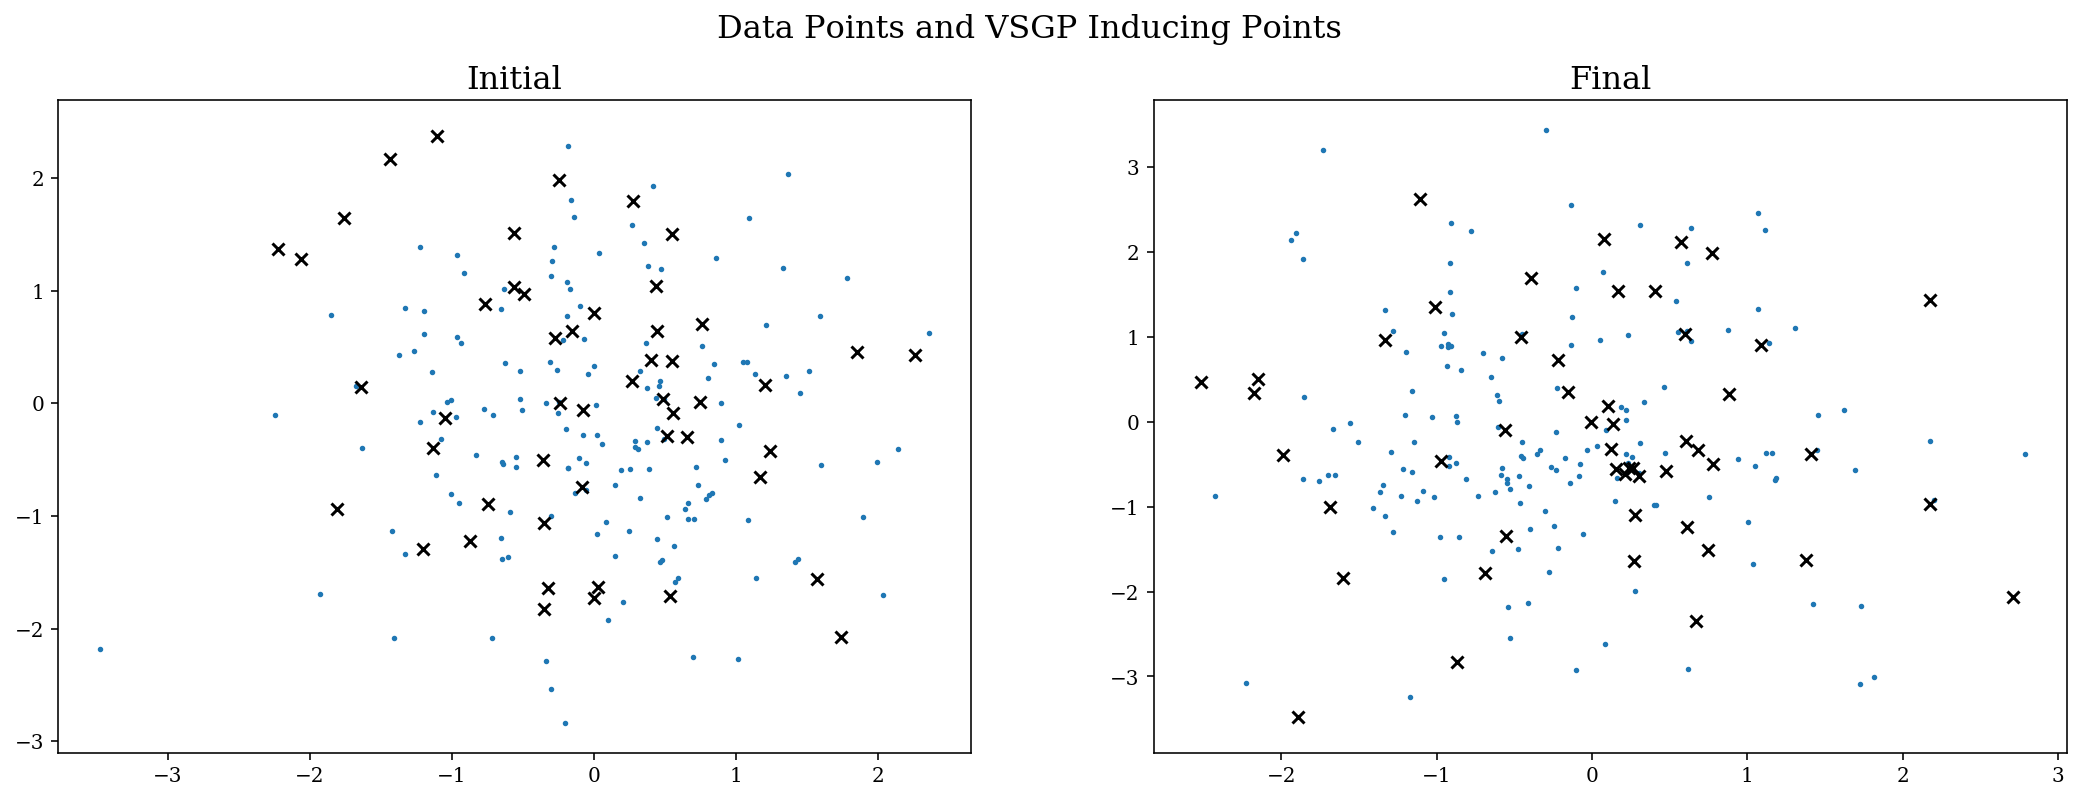

In [26]:
plot_before_after(X_init.numpy()[:,2:4],gplvm.X.clone().detach().cpu().numpy()[:,2:4],Xu.numpy(),gplvm.Xu.clone().detach().cpu().numpy(),labels=np.zeros(X_init.shape[0]))

In [29]:
plt.plot(losses)
plt.title(f'{losses[-1]}')
plt.show()

NameError: name 'losses' is not defined

Big insight of the day: in this SCA style model where each *residue* gets a latent variable assignment, we can use minibatch training for the GPLVM because these latent variables are global in the sense that they are shared across each protein sequence. This is a cool feature because for the "conventional" gplvm one is quite limited for how many latent variables you can learn when you have to be able to invert a matrix that scales like N^2 for the kernel of these points.

Also note that the ELBO loss increases with the size of the batch so I need to implement this CrossEntropy Calculation to acutal have an idea of how well im doing on a given batch.

In general though I think this works now that I figured out all the weird shaping issues. 

Also should probably implement a learning rate scheduler since it really seems like each minibatch hops you to a different local basin and at some point we should probably just commit to one and optimize there? Or do a better job picking batch sizes and number of gradient steps to take in each batch. 

In [6]:
oh_msa = np.eye(labels.shape[0])[msa]

In [15]:
oh_msa.shape

(4706, 159, 22)

In [16]:
marginals = oh_msa.sum(axis=0)/oh_msa.shape[0]

In [27]:
gplvm.kernel.lengthscale

AttributeError: 'Sum' object has no attribute 'lengthscale'

In [12]:
gplvm.kernel()

Sum(
  (kern0): RBF()
  (kern1): Matern52()
)

In [28]:
for name, param in gplvm.named_parameters():
    if 'lengthscale' in name:
        print(name)
        print(param)

kernel.kern0.kern0.kern0.lengthscale_unconstrained
Parameter containing:
tensor([1.0363, 1.1918, 6.9972, 0.1756, 6.9721], device='cuda:0',
       requires_grad=True)
kernel.kern0.kern0.kern1.lengthscale_unconstrained
Parameter containing:
tensor([1.4629, 1.6382, 5.3906, 0.3796, 5.3356], device='cuda:0',
       requires_grad=True)
kernel.kern0.kern1.lengthscale_unconstrained
Parameter containing:
tensor([1.9194, 2.1168, 5.2785, 0.5129, 5.2196], device='cuda:0',
       requires_grad=True)
kernel.kern1.lengthscale_unconstrained
Parameter containing:
tensor([5.0639, 5.0881, 6.0600, 2.1053, 6.0147], device='cuda:0',
       requires_grad=True)


In [35]:
print(gplvm.kernel.lengthscale)
print(gplvm.kernel.variance)

tensor([3.7597, 2.6009, 1.7713, 2.1190, 1.4756], device='cuda:0')
tensor(2.7459, device='cuda:0')


In [84]:
p1 = torch.randn(5).unsqueeze(0)
print(p1.softmax(1))
l1 = torch.eye(5)[2]
print(l1)

tensor([[0.2286, 0.0139, 0.0288, 0.5121, 0.2167]])
tensor([0., 0., 1., 0., 0.])


In [78]:
cce = torch.nn.CrossEntropyLoss(reduction='mean')

In [88]:
cce(p1,torch.LongTensor([3]))

tensor(0.6693)

In [122]:
loc, scale = gplvm(X_init.cuda())

In [123]:
loc.shape

torch.Size([500, 22, 159])

In [143]:
Yt = Y[torch.arange(batch_size)]

In [144]:
Yt.shape

torch.Size([500, 159])

In [145]:
cce(loc.cpu(),Yt.to(torch.long))

tensor(3.4325, grad_fn=<NllLoss2DBackward>)

In [111]:
ne=100
ns=50
nb = 200

In [138]:
preds = gplvm.likelihood(loc,scale).cpu()

In [146]:
preds.eq(Yt).sum().to(torch.float)/Yt.numel()

tensor(0.0587)

In [162]:
locf, scalef = gplvm(gplvm.X)
predsf = gplvm.likelihood(locf,scalef).cpu()
print(f'CCE final: {cce(locf.cpu(),Yt.to(torch.long))}')
print(f'Accuracy final: {predsf.eq(Yt).sum().to(torch.float)/Yt.numel()}')

CCE final: 1.8639965057373047
Accuracy final: 0.23729559779167175


In [157]:
ohmsa = np.eye(22)[msa]

In [65]:
lout = gplvm.kernel.lengthscale.clone().detach().cpu().numpy()
Xout = gplvm.X.clone().detach().cpu().numpy()

In [66]:
lout

array([1.5929563e+03, 1.3280771e+00, 1.4369437e+03, 1.8117710e+00,
       1.4390837e+03], dtype=float32)

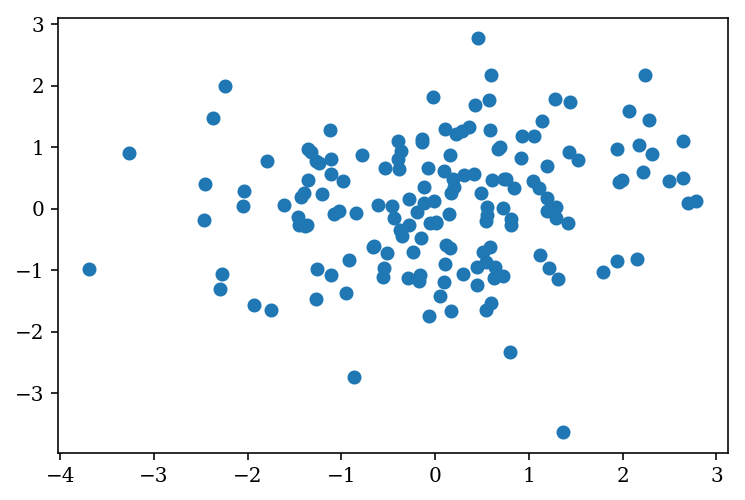

In [134]:
plt.scatter(Xout[:,2],Xout[:,0])

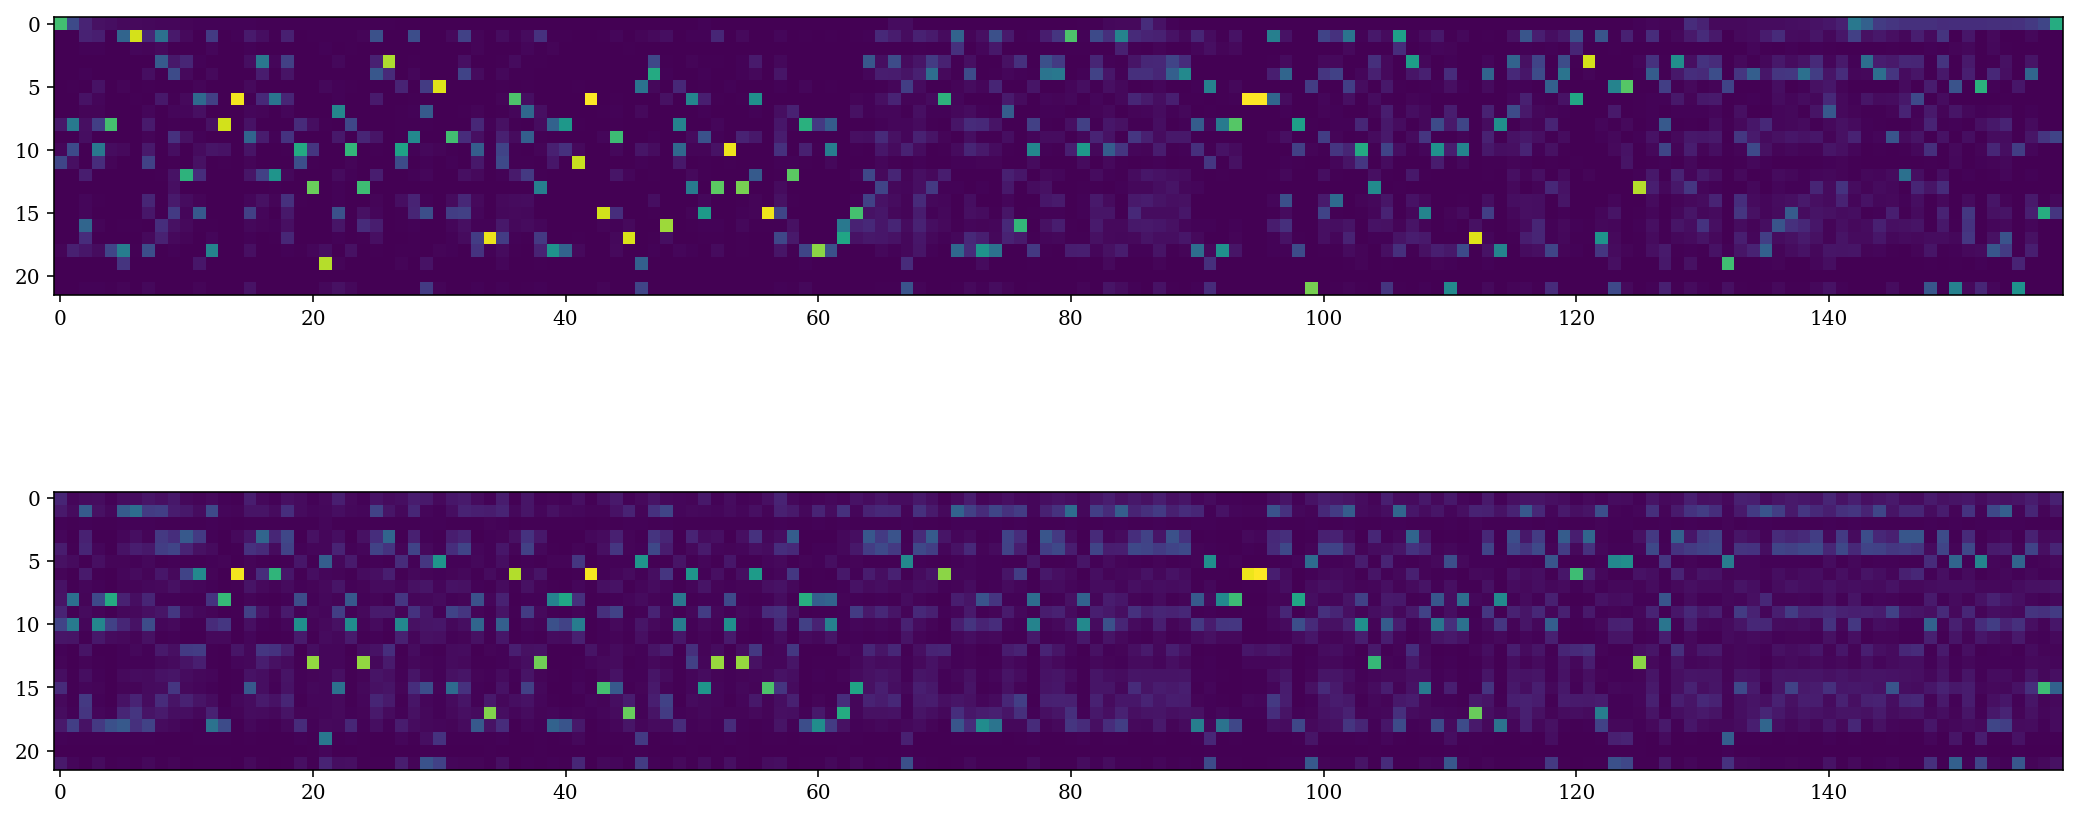

In [100]:
fig, ax = plt.subplots(2,1,figsize=(18,8))
ax[0].imshow(marginals.T)
ax[1].imshow(preds)
plt.show()

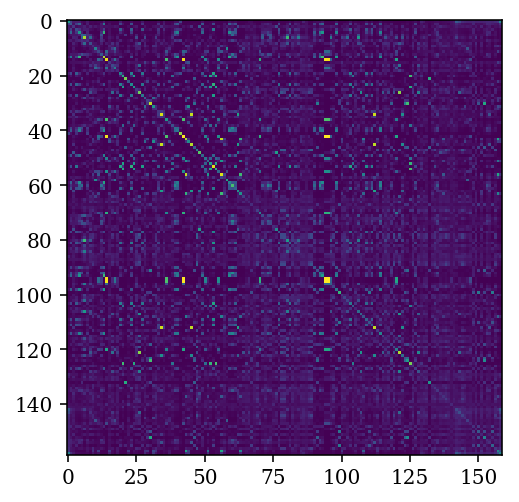

In [80]:
plt.imshow(np.cov(marginals))
plt.show()

In [ ]:
test_categorical_gplvm(gplvm.Y[torch.randperm])

In [123]:
loc, scale = gplvm(gplvm.X)
loc.cpu();scale.cpu();
loc = loc.mean(axis=0).cpu().detach()
loc = loc + 0.00001*torch.ones_like(loc)
pred = loc.softmax(0)

In [124]:
print(loc.shape)
tmarginals = torch.tensor(marginals.T)
tmarginals = (tmarginals + 0.00001*torch.ones_like(tmarginals)).softmax(0)
print(tmarginals.shape)

torch.Size([22, 159])
torch.Size([22, 159])


In [126]:
def kl_cat(p,q):
    tmp = p*torch.log(p/q)
    return tmp.sum(0).mean()

In [127]:
kl_cat(pred,tmarginals)

tensor(0.5798, dtype=torch.float64)

In [132]:
test = torch.randn(tmarginals.shape)
test = test.softmax(0)

In [133]:
kl_cat(tmarginals,test)

tensor(0.4749, dtype=torch.float64)

In [116]:
t = tmarginals*torch.log(tmarginals/pred)
print(t.sum(0))

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan, 0.7086,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan, 0.1305,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan, 

In [117]:
tmarginals/pred

tensor([[8.3652e+00, 1.1127e+01, 3.8409e+00,  ..., 2.9360e+00, 5.0813e+00,
         8.1861e+00],
        [0.0000e+00, 7.5860e-03, 5.4220e-01,  ..., 1.9176e-01, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.1015e+00,  ..., 1.8701e-01, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 3.0387e-02,  ..., 1.1963e-01, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.1846e-02, 1.5042e+00,  ..., 2.5087e-01, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64)

Compare the output of the gp (softmaxed) to the marginal distribution of the residue positions. Shouldnt be identical since were hoping to learn something about higher order structures but should probably be close (especially if youre of the opinion that conservation is the first order effect rather than coevolution.)

Need to select the dimensionality of the latent space with a DP or the clustering from MRD. JUST EMAIL THE DPGPLVM PEOPLE!!

In [1]:
import h5py

In [167]:
np.save('Xout_0.npy',Xout)
np.save('lout_0.npy',lout)
np.save('Xu_0.npy', gplvm.Xu.clone().detach().cpu().numpy())
np.save('u_loc_0.npy',gplvm.u_loc.clone().detach().cpu().numpy())
np.save('u_scale_tril_0.npy', gplvm.u_scale_tril.clone().detach().cpu().numpy())

In [170]:
np.save('X_loc_0.npy',gplvm.X_loc.clone().detach().cpu().numpy())
np.save('X_scale_tril_0.npy', gplvm.X_scale_tril.clone().detach().cpu().numpy())

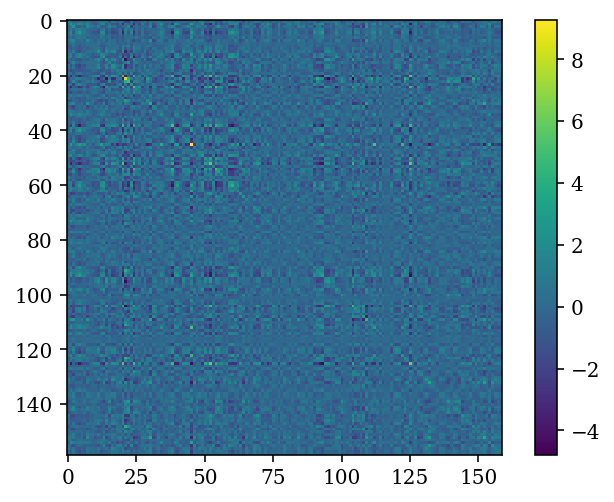

In [145]:
plt.imshow(norm_cov)
plt.colorbar()
plt.show()

In [144]:
norm_cov = np.cov(Xout)
norm_cov = (norm_cov - norm_cov.mean())/norm_cov.std()

In [149]:
Kx = gplvm.kernel(gplvm.X.clone()).detach().cpu().numpy()

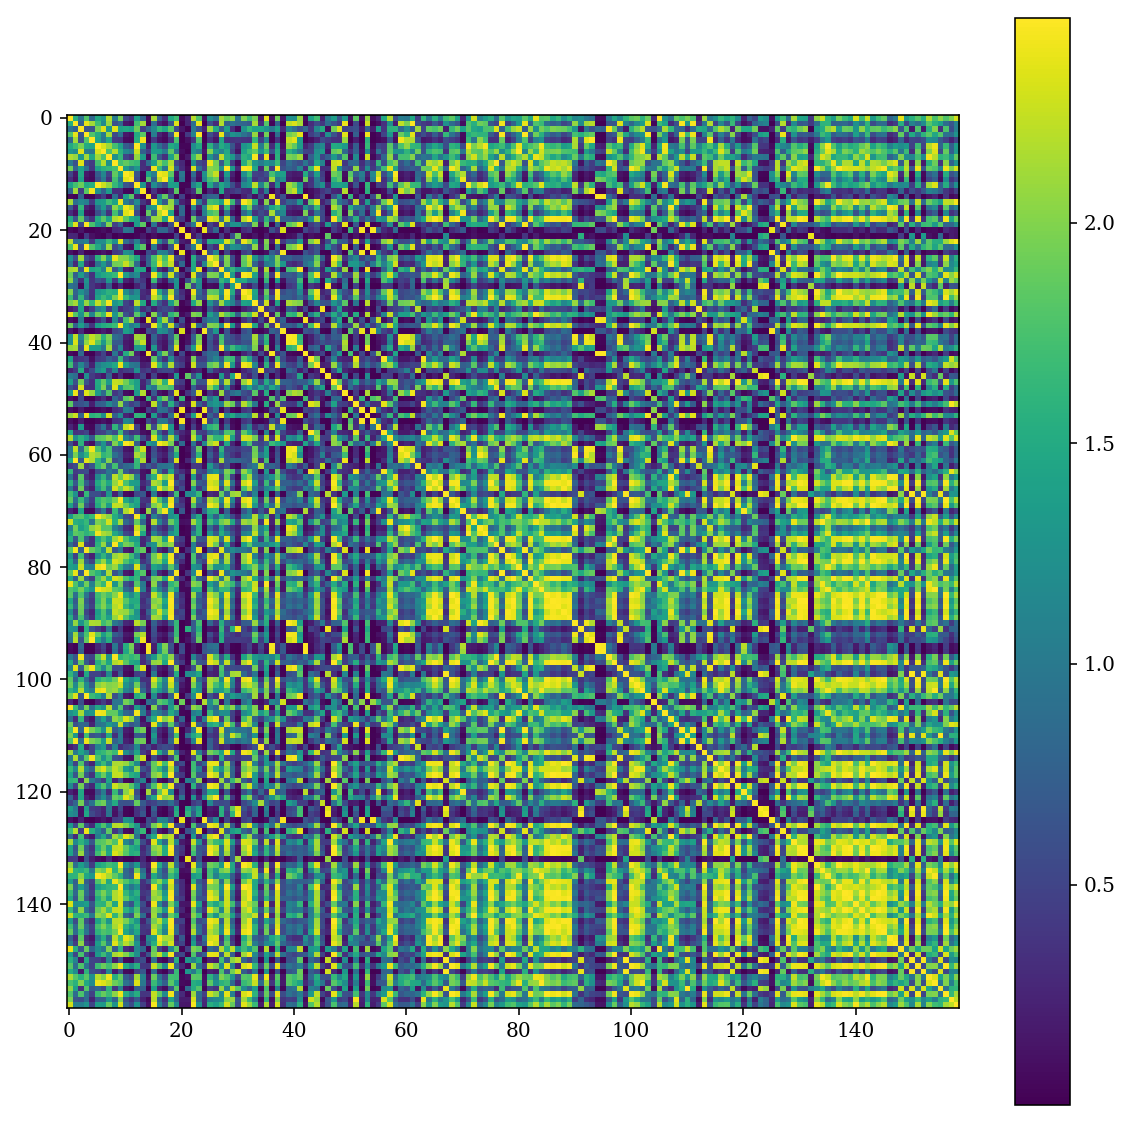

In [152]:
plt.figure(figsize=(10,10))
plt.imshow(Kx)
plt.colorbar()
plt.show()

In [17]:
gplvm.named_parameters()

TypeError: 'generator' object is not subscriptable

In [1]:
!ls

adam_elbo.png		 lout_0.npy	     u_scale_tril_0.npy
bmnist_cgplvm.ipynb	 __pycache__	     vsgplvm_mnist5k.save
cat_gplvm.ipynb		 pymc3_gmm.ipynb     X_loc_0.npy
cat_gplvm.png		 pyro_gmm.ipynb      Xout_0.npy
cgplvm.png		 pyro_gp_utils.py    X_scale_tril_0.npy
Coevolution_GPLVM.ipynb  pyro_log_reg.ipynb  Xu_0.npy
gLV_dynamics.ipynb	 README.md
gp_train_tqdm.py	 u_loc_0.npy


In [19]:
save_gp(gplvm, 'test_save.h5')

In [20]:

K = gp.kernels.RBF(input_dim=latent_dim,lengthscale=l0)
K = gp.kernels.Sum(K,gp.kernels.Matern52(input_dim=latent_dim,lengthscale=l0))
#Set up the model
test_load_gp = gp.models.VariationalSparseGP(X=X, y=None, kernel=K, Xu=Xu, 
                                      likelihood=likelihood,jitter=0.1, whiten=True,
                                      latent_shape = torch.Size([batch_size,labels.shape[0]]))
test_load_gp.set_prior('X',dist.Normal(torch.zeros_like(X_init[0]).cuda(),torch.ones_like(X_init[0]).cuda()))
test_load_gp.autoguide('X',dist.MultivariateNormal)

In [30]:
load_gp(test_load_gp,'test_save.h5')

Xu
u_loc
u_scale_tril_unconstrained
X_loc
X_scale_tril_unconstrained
kernel.kern0.variance_unconstrained
kernel.kern0.lengthscale_unconstrained
kernel.kern1.variance_unconstrained
kernel.kern1.lengthscale_unconstrained
